In [1]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

import colorsys

def ggplot_hue_palette(n, h_start=15, l=0.65, s=0.85):
    """
    Generate a list of n colors mimicking ggplot's discrete color palette,
    using evenly spaced hues around the color circle.
    
    Parameters
    ----------
    n : int
        Number of colors to generate.
    h_start : float, optional
        Starting hue angle in degrees. ggplot's default hue start is around 15 degrees.
    l : float, optional
        Lightness in [0,1]. Adjust this for brightness. Default: 0.65
    s : float, optional
        Saturation in [0,1]. Adjust this if colors are too muted or too vivid. Default: 0.85
    
    Returns
    -------
    palette : list of str
        List of hex color strings.
    """
    hues = [(h_start + 360.0 * i / n) % 360.0 for i in range(n)]
    palette = []
    for h_deg in hues:
        # Convert degrees to [0,1]
        h = h_deg / 360.0
        r, g, b = colorsys.hls_to_rgb(h, l, s)
        # Convert to hex
        palette.append('#{:02x}{:02x}{:02x}'.format(int(r*255), int(g*255), int(b*255)))
    return palette

<Figure size 800x800 with 0 Axes>

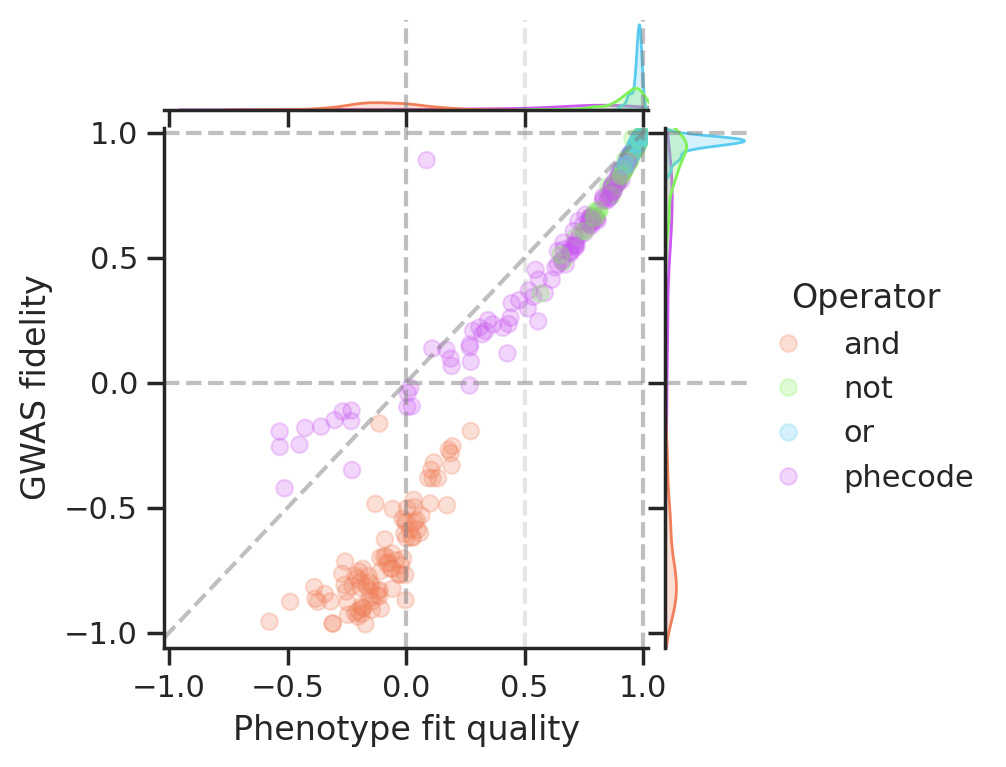

In [2]:
plot_df = (
    pl.scan_parquet("data/pheno_summary/direct_vs_indirect_anon.parquet")
    .join(pl.scan_parquet("data/gwas_summary/direct_vs_indirect_anon.parquet"), on=["kind", "phenotype", "k"], suffix="_gwas")
    .rename({"rsq": "rsq_pheno"})
    .with_columns(
        pl.col("phenotype").str.extract("^(and|or|not)").fill_null("phecode").alias("operator"),
        pl.col("k").cast(pl.Int32).cast(pl.String),
    )
    .collect()
)

custom_palette = ggplot_hue_palette(4)

sns.set_style("ticks")
sns.set_context("notebook")
sns.set_palette(custom_palette)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.family'] = 'sans-serif'
plt.figure(figsize=(4, 4))

(
    plot_df
    .filter(
        pl.col("rsq_pheno").ge(-0.97),
        pl.col("rsq_gwas").ge(-0.97),
        pl.col("k").eq("10")
    )
    .pipe(
        sns.jointplot, x="rsq_pheno", y="rsq_gwas", hue="operator", alpha=0.25, 
        xlim=(-1.02, 1.02), ylim=(-1.06, 1.02), hue_order=["and", "not", "or", "phecode"], 
        height=4, edgecolors="face", linewidths=0.75, marginal_kws={'common_norm':False}
    )
    .refline(x=0, y=0, linestyle="dashed", color="gray", alpha=0.5)
    .refline(x=1, y=1, linestyle="dashed", color="gray", alpha=0.5)
    .refline(x=0.5, linestyle="dashed", color="gray", alpha=0.2)
)
plt.axline((0, 0), slope=1, linestyle="dashed", color="gray", alpha=0.5)
plt.xlabel("Phenotype fit quality")
plt.ylabel("GWAS fidelity")
lgd = plt.legend(
    bbox_to_anchor=(1.17, 0.5), loc="center left", title="Operator", frameon=False
)
plt.savefig(
    "img/overall-performance-marginal.png", dpi=400, 
    format="png", bbox_extra_artists=(lgd,), bbox_inches='tight'
)

<Figure size 800x800 with 0 Axes>

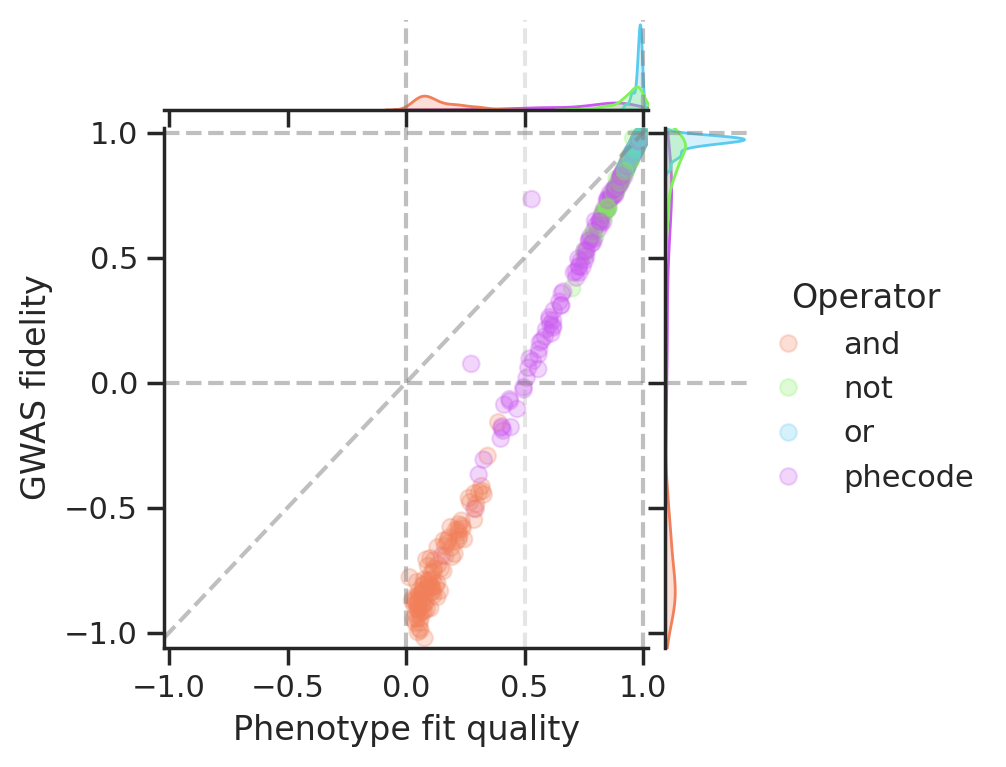

In [3]:
plot_df = (
    pl.scan_parquet("data/pheno_summary/direct_vs_indirect_non_anon.parquet")
    .join(pl.scan_parquet("data/gwas_summary/direct_vs_indirect_non_anon.parquet"), on=["kind", "phenotype"], suffix="_gwas")
    .rename({"rsq": "rsq_pheno"})
    .with_columns(
        pl.col("phenotype").str.extract("^(and|or|not)").fill_null("phecode").alias("operator"),
    )
    .collect()
)

custom_palette = ggplot_hue_palette(4)

sns.set_style("ticks")
sns.set_context("notebook")
sns.set_palette(custom_palette)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.family'] = 'sans-serif'
plt.figure(figsize=(4, 4))

(
    plot_df
    .pipe(
        sns.jointplot, x="rsq_pheno", y="rsq_gwas", hue="operator", alpha=0.25, 
        xlim=(-1.02, 1.02), ylim=(-1.06, 1.02), hue_order=["and", "not", "or", "phecode"], 
        height=4, edgecolors="face", linewidths=0.75, marginal_kws={'common_norm':False}
    )
    .refline(x=0, y=0, linestyle="dashed", color="gray", alpha=0.5)
    .refline(x=1, y=1, linestyle="dashed", color="gray", alpha=0.5)
    .refline(x=0.5, linestyle="dashed", color="gray", alpha=0.2)
    
)
plt.axline((0, 0), slope=1, linestyle="dashed", color="gray", alpha=0.5)
plt.xlabel("Phenotype fit quality")
plt.ylabel("GWAS fidelity")
lgd = plt.legend(
    bbox_to_anchor=(1.17, 0.5), loc="center left", title="Operator", frameon=False
)
plt.savefig(
    "img/linearization-performance-marginal.png", dpi=400, 
    format="png", bbox_extra_artists=(lgd,), bbox_inches='tight'
)